In [3]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
# from scipy.signal import welch
# from scipy.stats import kurtosis, skew, entropy

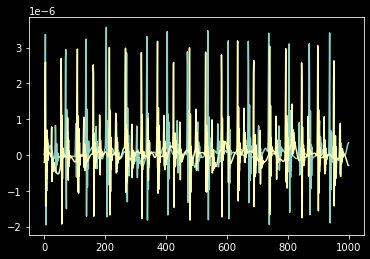

In [16]:
fs = 100
sampling_rate = 100
duration = 10

data_train = np.load('../Data/NewTry/sim_5000_0.1_90_140_train.npy')
data_test = np.load('../Data/NewTry/sim_3000_0.1_141_178_test.npy')

signals_train, S_train, D_train = data_train[:, :1000], data_train[:, -2], data_train[:, -1]
signals_test, S_test, D_test = data_test[:, :1000], data_test[:, -2], data_test[:, -1]


# print(signals_test.shape, S_train.shape, D_test[0])
# D_test, S_test

plt.plot(signals_train[35])
plt.plot(signals_test[35])


C:\Users\86189\AppData\Local\Temp\ipykernel_8336\2904125538.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


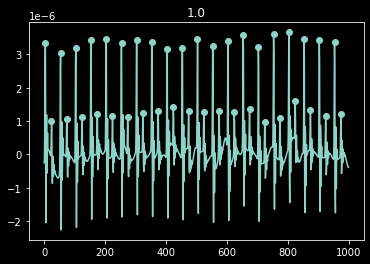

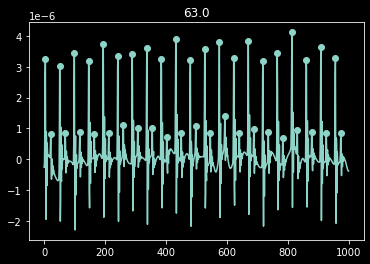

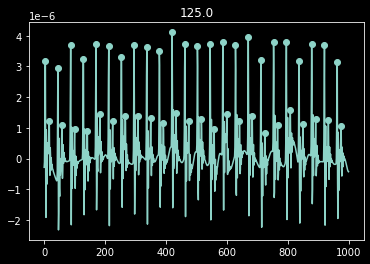

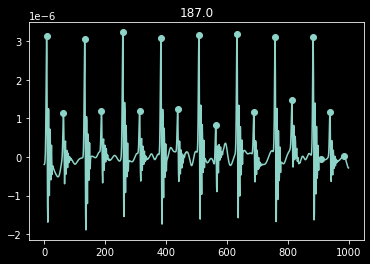

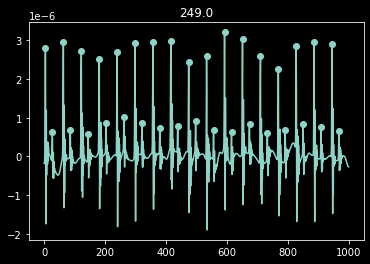

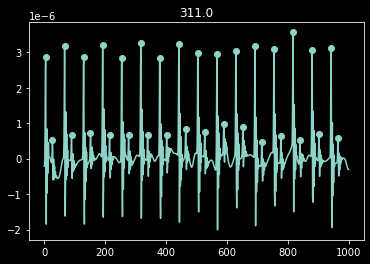

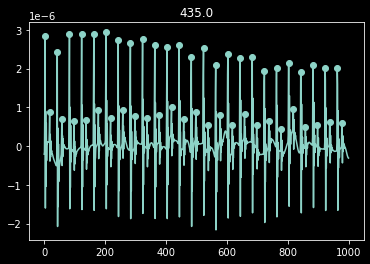

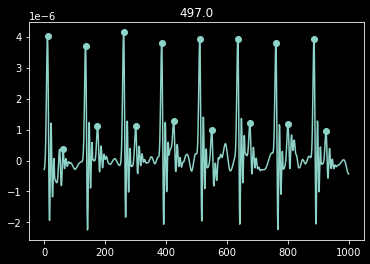

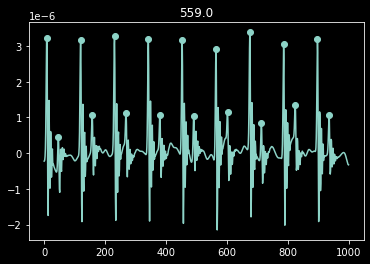

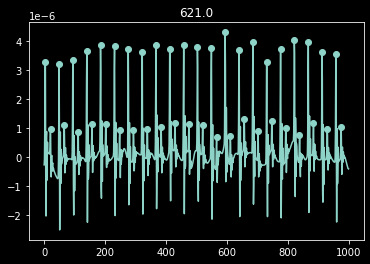

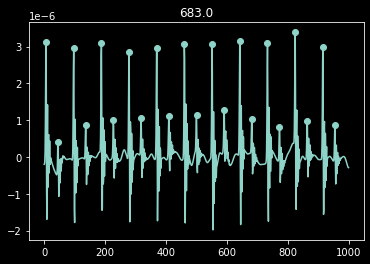

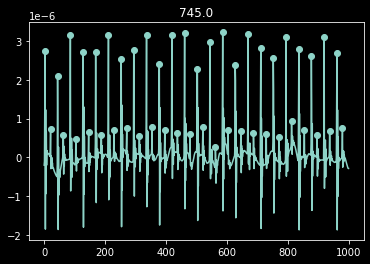

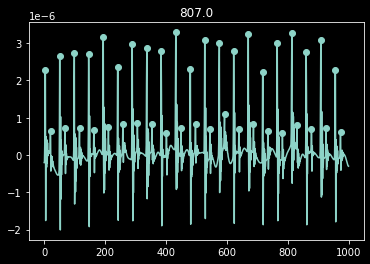

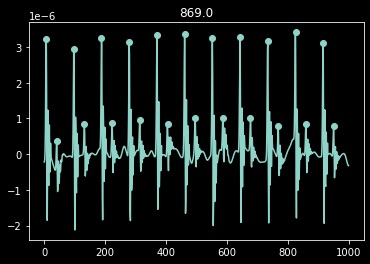

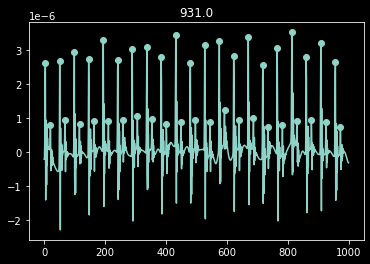

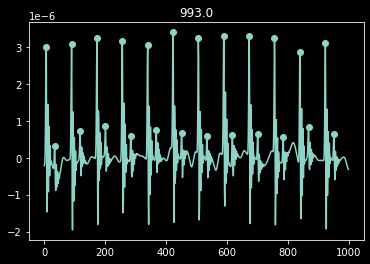

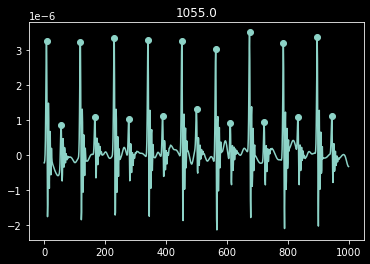

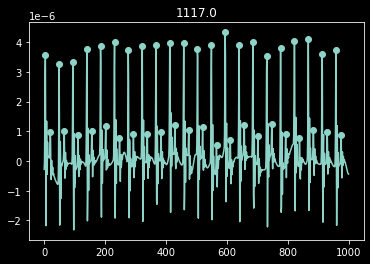

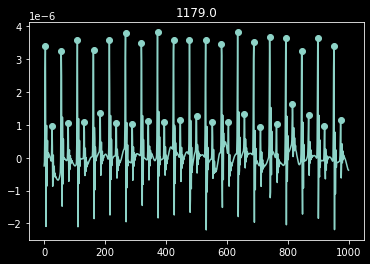

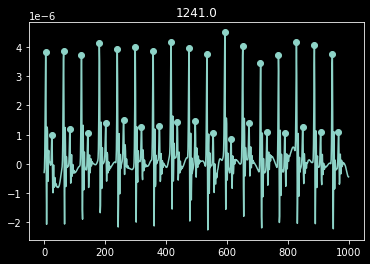

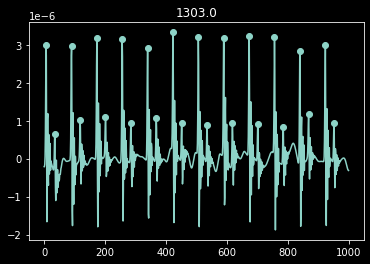

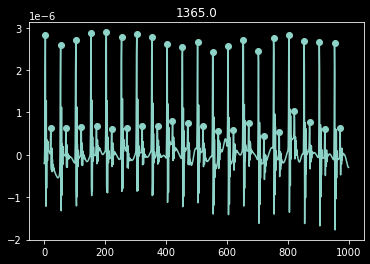

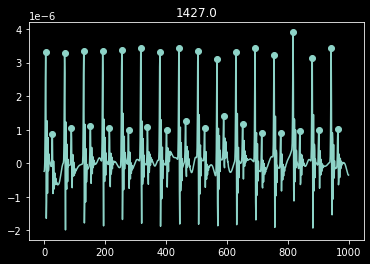

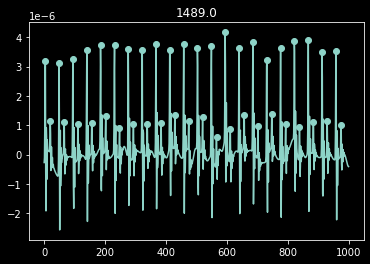

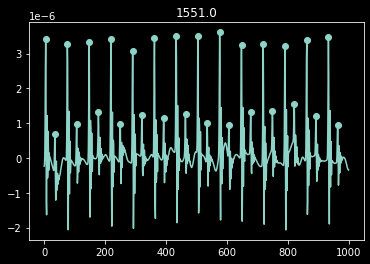

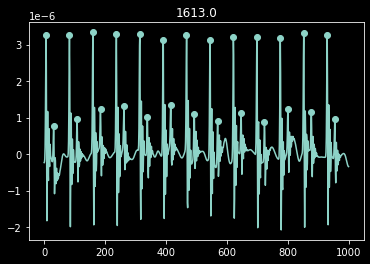

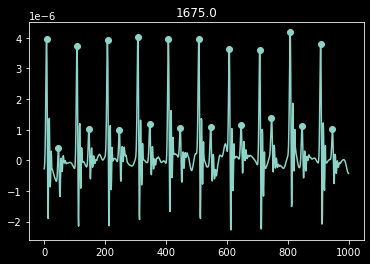

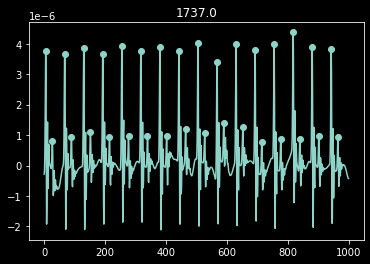

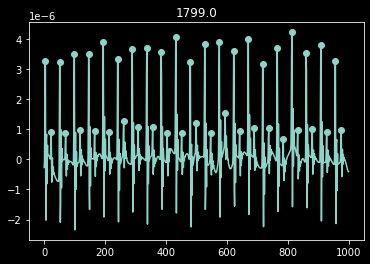

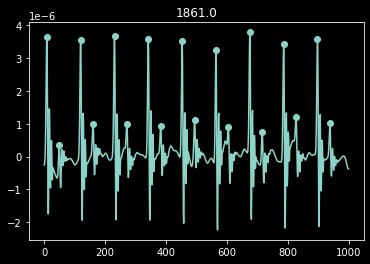

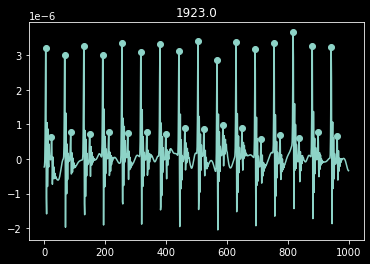

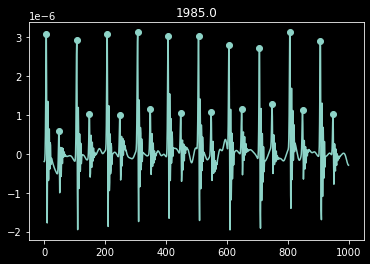

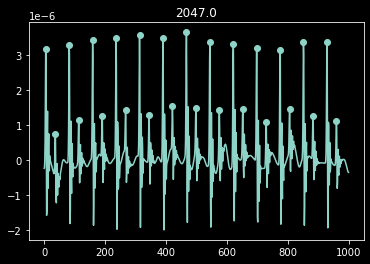

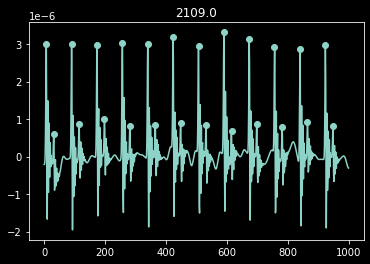

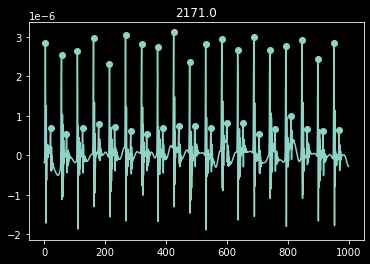

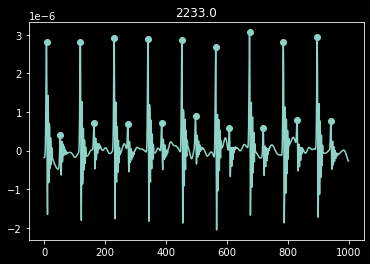

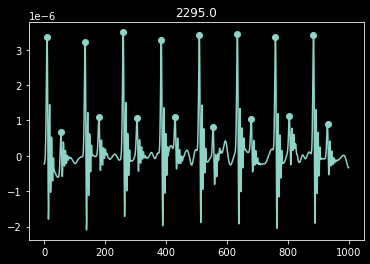

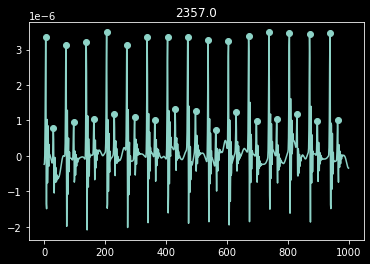

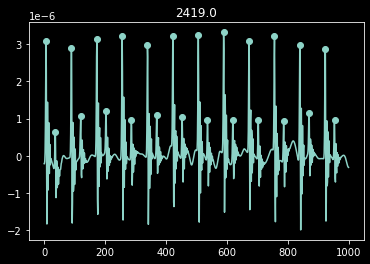

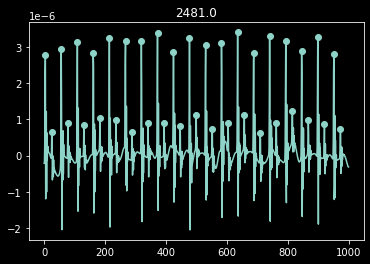

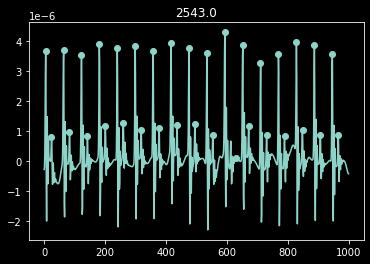

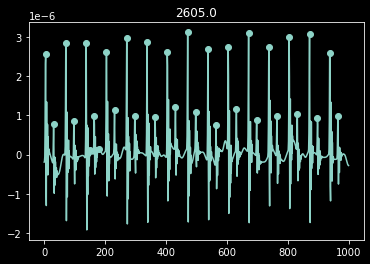

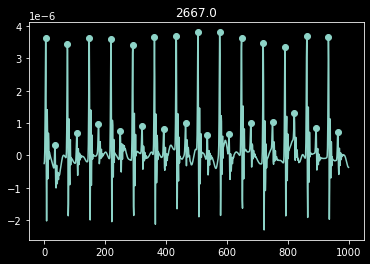

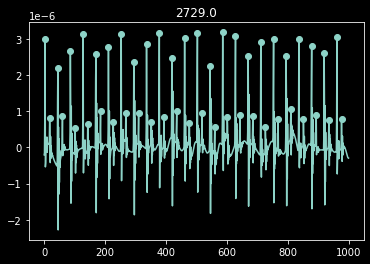

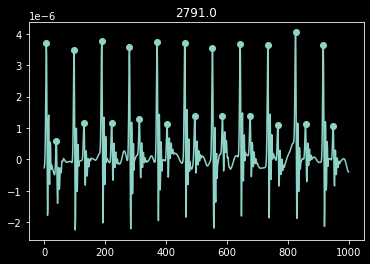

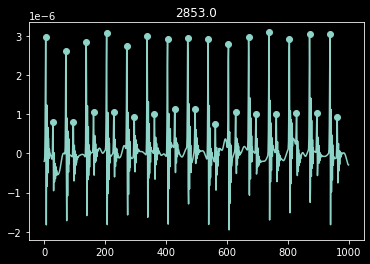

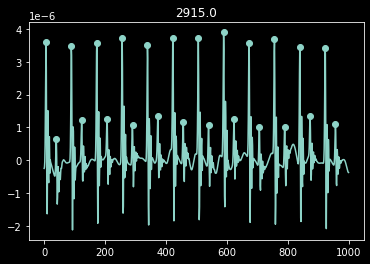

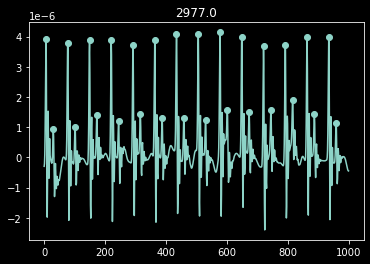

In [24]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, duration, sampling_rate):
    max = np.max(data_tmp)
    data_tmp = data_tmp / max

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal) 

    t_peaks = t[peak_indices] 
    peak_values = signal[peak_indices]  
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=10)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

for i in range(1, 3001, 62):
    peaks = get_peaks(signals_test[i], 10, 100)
    if max(signals_test[i]) > 0.1:
        continue
    if len(peaks) < 16:
        continue
    plt.figure()
    plt.title(str(data_test[i, 1001]))
    plt.plot(signals_test[i])
    plt.scatter(peaks, signals_test[i][peaks])

In [48]:

def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    max_index = np.argmax(filtered_a)
    min_index = np.argmin(filtered_a)

    filtered_a = np.delete(filtered_a, [max_index, min_index])

    max_index = np.argmax(filtered_a)
    min_index = np.argmin(filtered_a)

    filtered_a = np.delete(filtered_a, [max_index, min_index])


    return filtered_a




def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    max = np.max(data_tmp)
    # min = np.min(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / max

    data_tmp = data_tmp_raw / max

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    mag_0 = get_mag_0(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp_raw)

    features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1])

    return features


index_train, index_test = [], []
features_train, features_test = [], []
for i, signal in enumerate(signals_train):
    peaks = get_peaks(signal, duration, sampling_rate)
    if len(peaks) < 16 or max(signal) > 1: 
        # print(len(peaks))
        # # continue
        # plt.figure()
        # plt.plot(signal)
        # plt.scatter(peaks, signal[peaks]) 
        continue
    index_train.append(i)
    features = get_features(signal, peaks)
    features_train.append(features)

features_train = np.array(features_train)

for i, signal in enumerate(signals_test):
    peaks = get_peaks(signal, duration, sampling_rate)
    if len(peaks) < 16 or max(signal) > 1:
        continue
    index_test.append(i)
    features = get_features(signal, peaks)
    features_test.append(features)

features_test = np.array(features_test)

features_train.shape, features_test.shape, S_train[index_train].shape, S_test[index_test].shape



((4718, 8), (2822, 8), (4718,), (2822,))

In [49]:

print(np.corrcoef(features_train[:, 3], S_train[index_train])[0, 1], np.corrcoef(features_test[:, 3], S_test[index_test])[0, 1])
print(np.corrcoef(features_train[:, -1], D_train[index_train])[0, 1], np.corrcoef(features_test[:, -1], D_test[index_test])[0, 1])


-0.9893481285105797 -0.7551357542630084
-0.8981392721028996 -0.7896945514816155


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

BATCH_SIZE = 16

input_features = [4, 7, 8, 9, 10, 11]
input_size = len(input_features)

scaler = MinMaxScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

features_train_ft = torch.FloatTensor(features_train[:, input_features])
features_test_ft = torch.FloatTensor(features_test[:, input_features])

S_train_ft = torch.FloatTensor(S_train)
S_test_ft = torch.FloatTensor(S_test)
D_train_ft = torch.FloatTensor(D_train)
D_test_ft = torch.FloatTensor(D_test)

train_dataset_S = TensorDataset(features_train_ft, S_train_ft)
train_dataset_D = TensorDataset(features_train_ft, D_train_ft)
test_dataset_S = TensorDataset(features_test_ft, S_test_ft)
test_dataset_D = TensorDataset(features_test_ft, D_test_ft)

train_dataset = train_dataset_S
test_dataset = test_dataset_S

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleMLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden3 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden4 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden5 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.hidden1(x))
        x = self.sigmoid(self.hidden2(x))
        x = self.sigmoid(self.hidden3(x))
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.output(x)
        return x


# input_size = 23
hidden_size1 = input_size 
hidden_size2 = hidden_size1 // 2
output_size = 1


model = SimpleMLP(input_size, hidden_size1, hidden_size2, output_size)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000

for epoch in range(num_epochs):
    losses = []
    for data, label in train_loader:
        outputs = model(data)
        loss = criterion(outputs, label)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4f}')


    test_losses = []
    for data, label in test_loader:
        outputs = model(data)
        loss = criterion(outputs, label)
        test_losses.append(loss.item()) 

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_losses):.4f}')

#
# with torch.no_grad():
    # predictions = model(x_test)

# print("Predictions:", predictions)


IndexError: index 8 is out of bounds for axis 1 with size 8

In [23]:
# features_train_ft S_train
p1s = []
p2s = []
# for i in range(len(features_train[7])):
p1 = np.corrcoef(features_train[:, 7], D_train)[0, 1]
print(p1)

# for i in range(len(features_test_ft[0])):
print(np.corrcoef(features_test[:, 7], D_test)[0, 1])

-0.6344310010192135
-0.5988296894209152


In [42]:
from sklearn.linear_model import LinearRegression as LR  # 线性回归
# from sklearn.model_selection import train_test_split     # 划分训练测试集
# from sklearn.datasets import fetch_california_housing as fch  # 加利福尼亚房屋价格数据集
# import pandas as pd

# 3.建模
reg = LR().fit(features_train[:, 3].reshape(-1, 1), S_train[index_train])
yhat = reg.predict(features_test[:, 3].reshape(-1, 1))
np.mean(np.abs(yhat - S_test[index_test]))


1.760935846430051

In [51]:

# 3.建模
reg = LR().fit(features_train[:, -1].reshape(-1, 1), D_train[index_train])
yhat = reg.predict(features_test[:, -1].reshape(-1, 1))
np.mean(np.abs(yhat - D_test[index_test]))


4.092013970064011

In [52]:


# 3.建模
reg = LR().fit(features_train[:, 6:], D_train[index_train])
yhat = reg.predict(features_test[:, 6:])
np.mean(np.abs(yhat - D_test[index_test]))


4.03102789430678